Importing the libraries

In [61]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Loading the dataset

In [62]:
data='customer_booking.csv'

In [63]:
import chardet

with open('customer_booking.csv', 'rb') as rawdata:
  result = chardet.detect(rawdata.read(100000))

print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [64]:
df = pd.read_csv('customer_booking.csv', encoding='ISO-8859-1')

In [65]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


Dropping the columns with too many unique values

In [66]:
df.drop('route',axis=1, inplace=True)

 We can observe that, we have got some non numeric columns.
 First up, lets map the week days

In [67]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [68]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [69]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,India,1,0,1,5.52,0


Convert country names to continent names and then assigning these continent names to a new column 

This way we can drop the booking_origin column which has too mnay unique values

In [70]:
import pycountry_convert as pc

continent = []
index = []

df['booking_origin'] =  df['booking_origin'].replace('Myanmar (Burma)', 'Myanmar')

for i in range(len(df)):
    country = df['booking_origin'][i]
    #print(country)
    try :
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_name = pc.country_alpha2_to_continent_code(country_code)
        continent.append(continent_name)
    except:
        continent.append('Others')

df['booking_continent'] = continent

In [71]:
df['booking_continent'].value_counts()

booking_continent
AS        29740
OC        18960
EU          578
NA          525
Others       87
AF           69
SA           41
Name: count, dtype: int64

In [72]:
df.drop('booking_origin',axis=1, inplace=True)

Identify the outliners

In [73]:
# quantile stats description for numerical columns

nmric_cols = df.select_dtypes(include='number').columns
quantile_stat = {}

for col in nmric_cols:
    range_quartile = df[col].max() - df[col].min()
    interquartile = df[col].quantile(0.75) - df[col].quantile(0.25)
    lower_bound = df[col].quantile(0.25) - 1.5*interquartile
    higher_bound = df[col].quantile(0.75) + 1.5*interquartile
    
    quantile_stat[col] = [range_quartile, interquartile, lower_bound, higher_bound]
    
quantile_stat = pd.DataFrame(quantile_stat).T
quantile_stat.columns = ['range', 'interquartile', 'lower_bound', 'higher_bound']
quantile_stat = pd.concat([df.describe(include='number').T, quantile_stat], axis=1)

quantile_stat['low_outliers'] = np.vectorize(lambda x, y: 1 if x>y else 0)(quantile_stat['lower_bound'], quantile_stat['min'])
quantile_stat['high_outliers'] = np.vectorize(lambda x, y: 1 if x<y else 0)(quantile_stat['higher_bound'], quantile_stat['max'])

quantile_stat.T


,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000
range,8.000000,867.000000,778.00000,23.00000,6.000000,1.000000,1.000000,1.000000,4.830000,1.000000
interquartile,1.000000,94.000000,23.00000,8.00000,3.000000,1.000000,1.000000,1.000000,3.210000,0.000000


Remove the outliners

In [74]:
from scipy import stats

num = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

print(f'Total rows before delete outlier : {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in num:
    zscore = abs(stats.zscore(df[col]))
    filtered_entries = (zscore < 3) & filtered_entries
    df = df[filtered_entries]
    
print(f'Total rows after delete outlier : {len(df)}')

Total rows before delete outlier : 50000
Total rows after delete outlier : 47115


Normalising the data

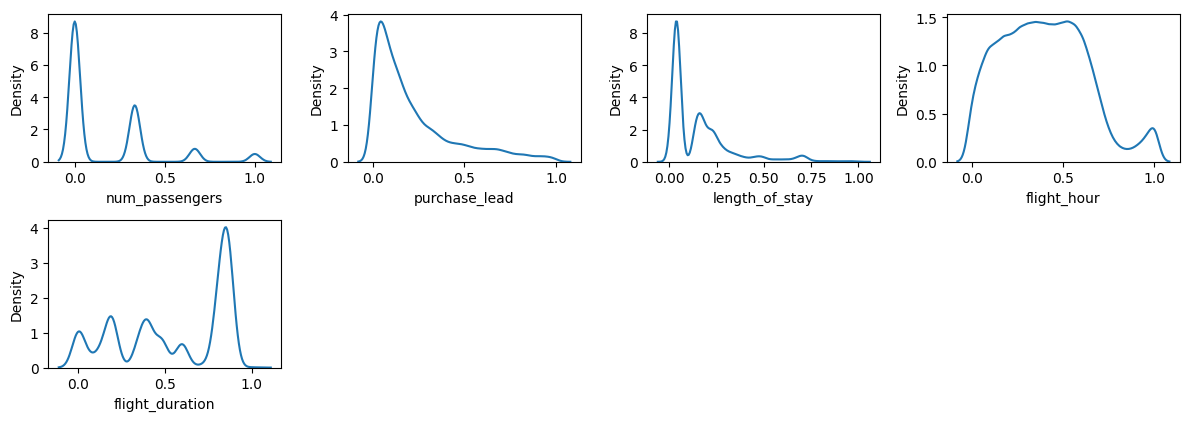

In [75]:
from sklearn.preprocessing import Normalizer

num_max = df[num].max()
num_min = df[num].min()

num_features = (df[num] - num_min) / (num_max - num_min)
num_features.head()

df[num] = num_features

plt.figure(figsize=(12,8))

for i, column in enumerate (df[num].columns, 1):
    plt.subplot(4,4,i)
    sns.kdeplot(data=df, x=df[column])
    plt.tight_layout()

Encoding the categorical data

In [76]:
from sklearn import preprocessing

label_encode = ['sales_channel']
one_hot = ['booking_continent']
                
mapping_trip_type = {
    'RoundTrip'  : 0,
    'OneWay'     : 1,
    'CircleTrip' : 2
}               

df['trip_type'] = df['trip_type'].map(mapping_trip_type)

df['sales_channel'] = preprocessing.LabelEncoder().fit_transform(df['sales_channel'])

onehots = pd.get_dummies(df['booking_continent'], prefix='booking_continent')
df = df.join(onehots)



In [77]:
df.drop('booking_continent', axis=1, inplace=True)

In [78]:
df.head(5)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,booking_continent_AF,booking_continent_AS,booking_continent_EU,booking_continent_NA,booking_continent_OC,booking_continent_Others,booking_continent_SA
0,0.333333,0,0,0.742210,0.150794,0.304348,6,1,0,0,0.175983,0,False,False,False,False,True,False,False
1,0.000000,0,0,0.317280,0.158730,0.130435,6,0,0,0,0.175983,0,False,False,False,False,True,False,False
2,0.333333,0,0,0.688385,0.174603,0.739130,3,1,1,0,0.175983,0,False,True,False,False,False,False,False
3,0.000000,0,0,0.271955,0.246032,0.173913,6,0,0,1,0.175983,0,False,False,False,False,True,False,False
4,0.333333,0,0,0.192635,0.174603,0.652174,3,1,0,1,0.175983,0,False,True,False,False,False,False,False


Splitting the dataset

In [84]:
from sklearn.model_selection import train_test_split, GridSearchCV

x = df.drop(columns=['booking_complete'], axis=1)
y = df['booking_complete']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

The target column is unbalanced

So, we apply oversampling

In [ ]:
df.booking_complete.value_counts()

In [85]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2)
x_over, y_over = sm.fit_resample(x_train, y_train.ravel())

Evaluation functions

In [86]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def confusionmatrix(predictions):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return disp.plot()

def eval_classification(model):
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_over)
  
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_over, y_pred_train))

Model

In [87]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 0)

In [91]:
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

Result

Accuracy (Test Set): 0.85
Precision (Test Set): 0.47
Recall (Test Set): 0.07
F1-Score (Test Set): 0.12
roc_auc (test-proba): 0.53
roc_auc (train-proba): 0.74


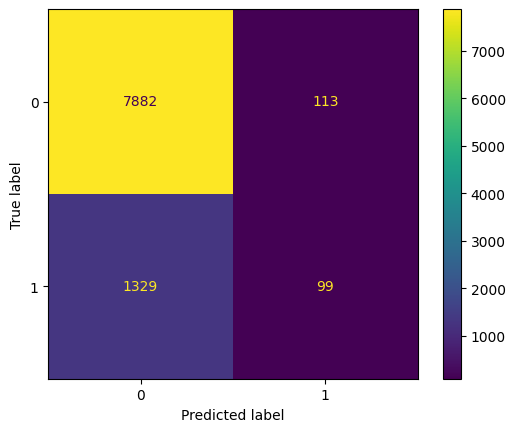

In [92]:
predictions = rf.predict(x_test)
confusionmatrix(predictions)
eval_classification(rf)

Displaying the important features

Text(0.5, 0, 'Random Forest Feature Importance')

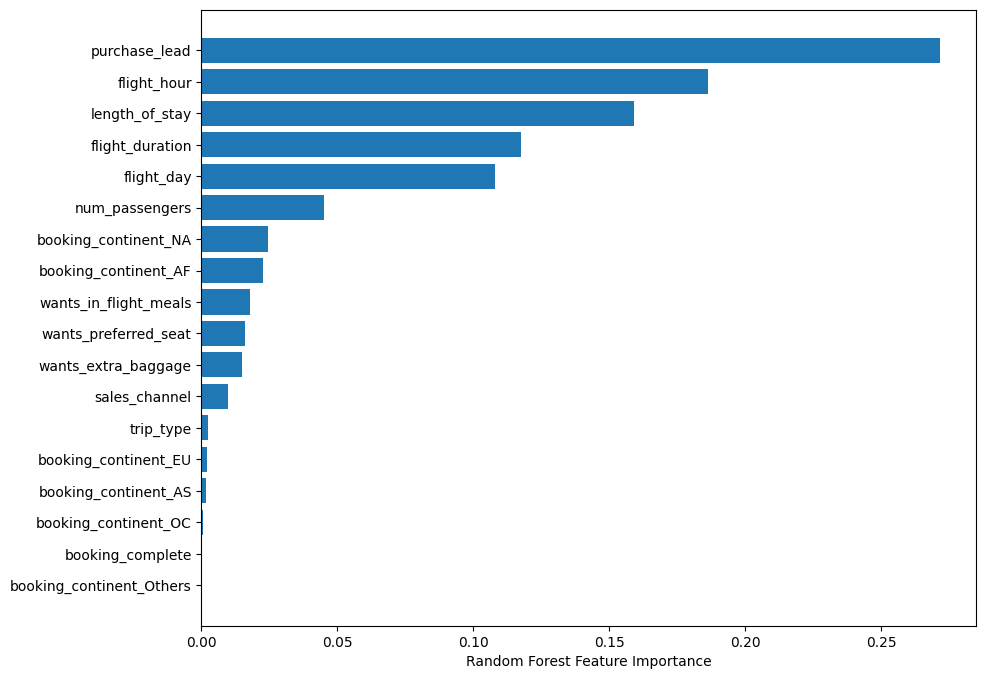

In [97]:
plt.figure(figsize=(10,8))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df.iloc[:,:-1].columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
